In [1]:
import pathlib
from os.path import sep, exists
from os import mkdir, makedirs, getcwd

import h5py
import pandas as pd
import json
import numpy as np
import scipy as sp
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt
import dask.array as da
import skimage 

import SessionTools as st 
import SessionTools.two_photon

%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [2]:
basedir = pathlib.PurePath('/media/mplitt/SSD_storage/2PData/12_16_2022/EPG_GCaMP7f_CsChrimsontdT_fly1/fixed_cw_remapping-000/')
session = "fixed_cw_remapping-000"
basename_input = pathlib.Path(basedir.joinpath(session))
metadata = st.two_photon.metadata.read(basename_input)

h5name = '/media/mplitt/SSD_storage/2P_scratch/test.h5'
if not exists(h5name):
    tiff_data = st.two_photon.tiff_tools.read(basename_input, 
                                            metadata['size'],metadata['layout'])
    st.two_photon.tiff_tools.convert_to_hdf5(tiff_data,'/media/mplitt/SSD_storage/2P_scratch/test.h5', overwrite=True)

In [3]:
f = h5py.File(h5name)
data = f['/data']
# data = da.from_array(f['/data'], chunks = (2,1000,*f['/data'].shape[-3:]))

In [4]:
ref_img = st.two_photon.motion_correction.make_ref_img(data,0)


In [5]:
ref_img.shape

(2, 7, 208, 259)

In [6]:
data = data[:]
data_corr, shifts, error, diffphase = st.two_photon.motion_correction.align_data_chunk(data, ref_img[0,:,:,:], in_place=False)

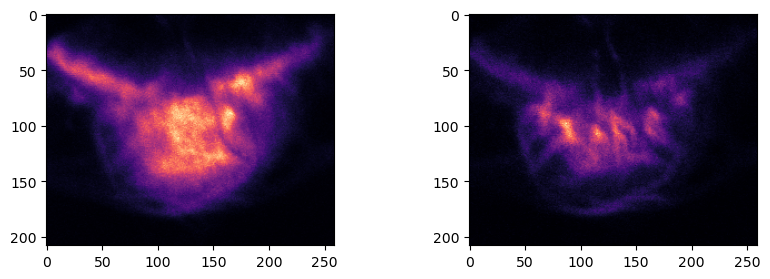

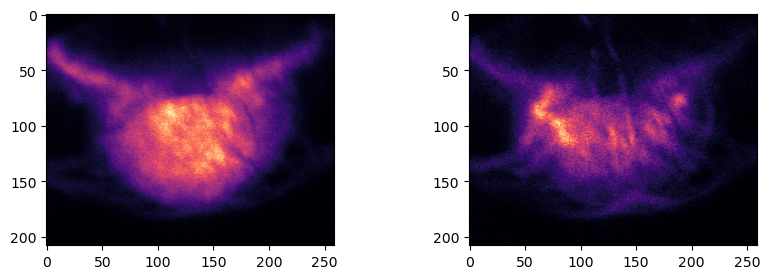

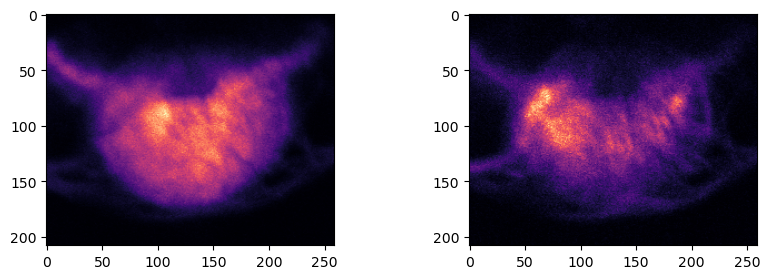

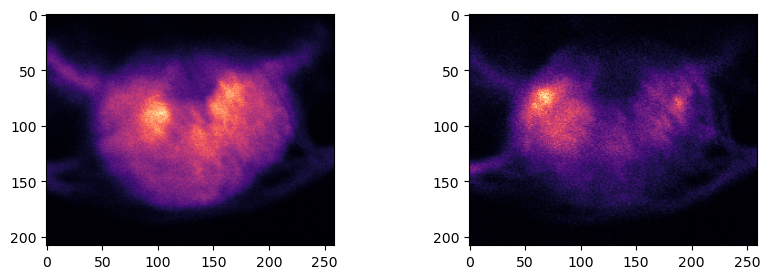

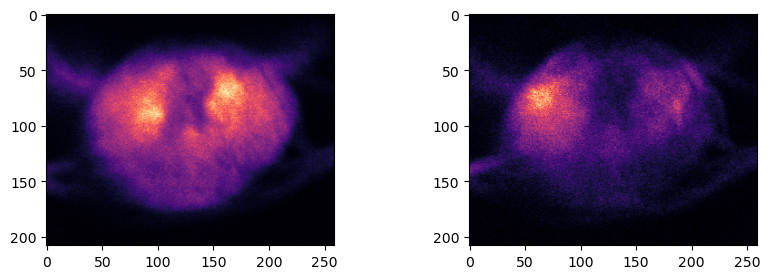

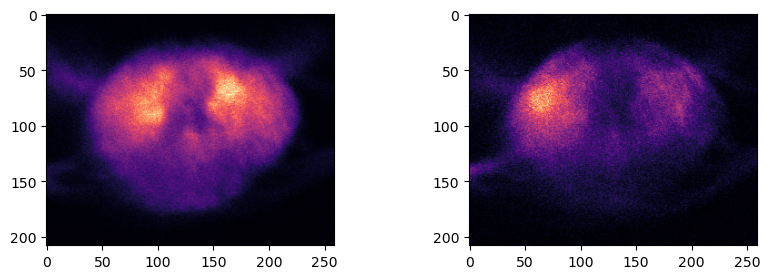

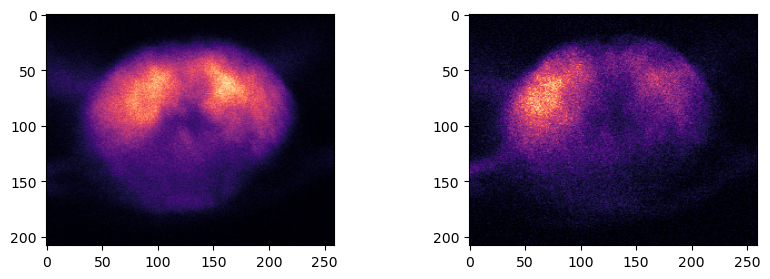

In [7]:
for i in range(7):
    fig, ax = plt.subplots(1,2, figsize= [10,3])
    ax[0].imshow(data_corr[0,:,i,:,:].mean(axis=0), cmap='magma')
    ax[1].imshow(data_corr[1,:,i,:,:].mean(axis=0), cmap='magma')

In [8]:
import napari



In [17]:
viewer = napari.view_image(np.squeeze(ref_img[0,:,:,:]), name = 'PMT1' )
viewer.add_image(np.squeeze(ref_img[1,:,:,:]), name = 'PMT2')
viewer.add_labels((0*ref_img[0,:,:,:]).astype(int), name='inner_ring')
viewer.add_labels((0*ref_img[0,:,:,:]).astype(int), name='outer_ring')



<Labels layer 'outer_ring' at 0x7f1e834c3fd0>

In [58]:
inner_ring = viewer.layers['inner_ring'].data
outer_ring = viewer.layers['outer_ring'].data
com = np.zeros((2,inner_ring.shape[0]))*np.nan
for z in range(inner_ring.shape[0]):
    
    plane = inner_ring[z,:,:]
    if plane.ravel().sum() > 0 :
        com[:,z] = sp.ndimage.center_of_mass(plane)


In [86]:
import itertools
phase_mask = np.nan*np.zeros(inner_ring.shape)
print(inner_ring.shape)
for z in range(7):
    for row,col in itertools.product(range(inner_ring.shape[1]),
                                 range(inner_ring.shape[2])):
        if com[0,z] != np.nan:
            phase_mask[z,row,col] = np.arctan2(col-com[1,z],row-com[0,z]) +np.pi
            
phase_donut = np.nan*np.zeros(phase_mask.shape)
inds = (outer_ring-inner_ring)>0
phase_donut[inds] = phase_mask[inds]

masks=np.zeros(ref_img.shape)
bin_edges = np.linspace(-1E-3,2*np.pi+1E-3, num=17)
for mask_i, (ledge, redge) in enumerate(zip(bin_edges[:-1].tolist(),bin_edges[1:].tolist())):
    bin_inds = (phase_donut>=ledge) & (phase_donut<redge)
    masks[bin_inds] = mask_i +1


(7, 208, 259)
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 ...

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... F

In [87]:
viewer.add_labels(masks.astype(int), name='rois')

<Labels layer 'rois [1]' at 0x7fc2ddf61420>

In [92]:
napari_data = {}
for layer in viewer.layers:
    napari_data[layer.name] = layer.data

In [93]:
import cloudpickle
with open('/media/mplitt/SSD_storage/2P_scratch/testdata_napari.csv', 'wb') as f:
    cloudpickle.dump(napari_data, f)


[nan nan]
[nan nan]
[ 66.16666667 128.01253133]
[ 66.81173261 129.77626194]
[ 90.48911652 124.74647887]
[ 92.71111111 128.31965812]
[ 93.9156051  122.70382166]


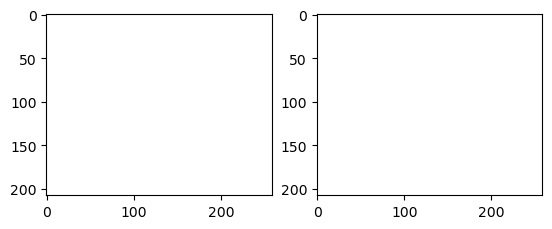

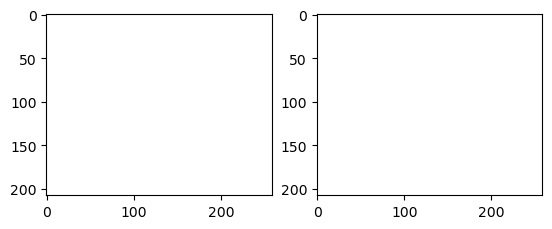

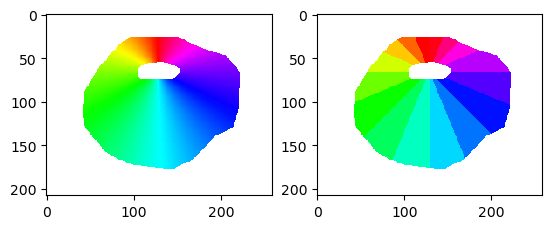

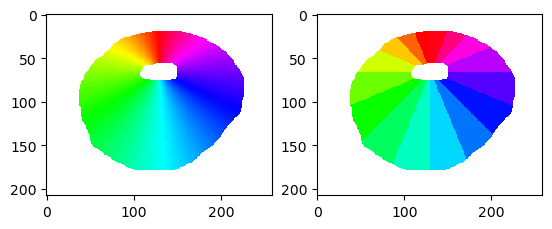

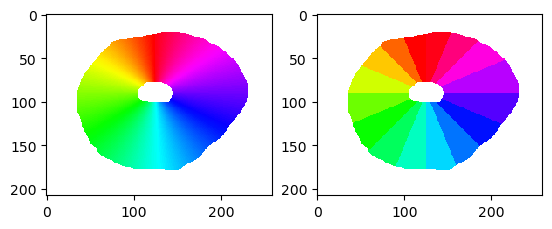

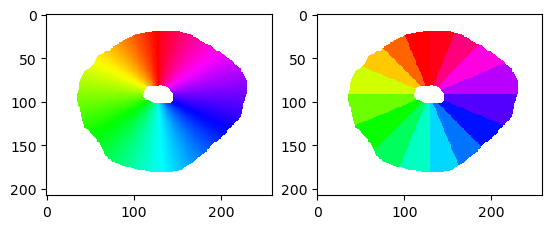

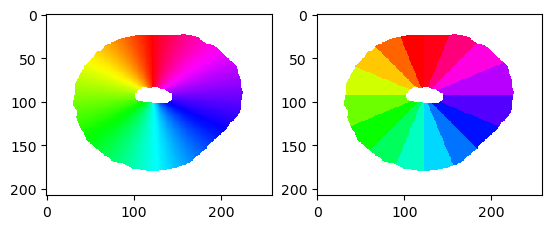

In [85]:

for z in range(7):
    print(com[:,z])
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(phase_donut[z,:,:], cmap='hsv', interpolation='none')
    ax[1].imshow(masks[z,:,:], cmap='hsv', interpolation='none')

In [73]:
phase_donut[2,30:40,115:135]

array([[3.45372754e-01, 3.20679524e-01, 2.95574571e-01, 2.70079925e-01,
        2.44220322e-01, 2.18023162e-01, 1.91518415e-01, 1.64738482e-01,
        1.37718015e-01, 1.10493693e-01, 8.31039544e-02, 5.55886984e-02,
        2.79889470e-02, 3.46488327e-04, 6.25588881e+00, 6.22828747e+00,
        6.20076959e+00, 6.17337622e+00, 6.14614727e+00, 6.11912124e+00],
       [3.54401546e-01, 3.29161776e-01, 3.03479251e-01, 2.77376963e-01,
        2.50880942e-01, 2.24020217e-01, 1.96826720e-01, 1.69335145e-01,
        1.41582748e-01, 1.13609095e-01, 8.54557696e-02, 5.71660255e-02,
        2.87844077e-02, 3.56341075e-04, 6.25511301e+00, 6.22672967e+00,
        6.19843707e+00, 6.17027979e+00, 6.14230112e+00, 6.11454268e+00],
       [3.63893543e-01, 3.38087289e-01, 3.11804204e-01, 2.85068236e-01,
        2.57906753e-01, 2.30350504e-01, 2.02433531e-01, 1.74193018e-01,
        1.45669072e-01, 1.16904450e-01, 8.79442194e-02, 5.88353736e-02,
        2.96263923e-02, 3.66770569e-04, 6.25429183e+00, 6.2250